Use a different data and use the model provided in ICP6 to perform Text generation. You must make 4 changes (for example adding more layers to model, changing hyperparameters etc ) in the source code. Report your findings in detail.
Note: please indicate in your reports which 4 changes you made in the source code and why in your opinion these changes are logical. 

The four hyper-parameters changed are(also few more for testing purposes):
-	Epochs, Buffer size, Optimizer, Embedding dim, sequence length, batch size, temperature:

o	The number of Epochs is correlated with number of optimizations that are applied during training. Since having more rounds the training error will be reduced. But there is a high chance of overfitting the training data and it will start to lose performance. So, based on what I was testing the higher number of Epochs gave me the best result. 

o	The optimizer I decided to use was ‘Adamax’ which is a variant of ‘Adam. It is based on the infinity norm. In most cases it is found to be better and I wanted to test that out with my model. Based on my testing ‘Adamax’ did perform better. 

o	Few things would need be considered when changing the embedding dim matrix. Since, not every word would get replaced by a vector, and instead it is replaced by index. This index can be used to look up the embedding matrix. Also, the embedded vectors are updated frequently during the training process it would make since for this case to increase the embedding dim to large number if the dataset is large. Which was the case when I decided to use Hamlet by Shakespeare. 

o	Batch size can be one of the most important hyperparameters that will need to be tuned. One of the benefits of going with a smaller batch size is that it will not converge to the global optima. Also, a smaller batch size is known to have a faster convergence to good solutions. This means that the smaller batch sizes allow the model to start learning before looking at all the data. I decided to go with slightly higher batch size but not too high. I wanted to have all the variable looked at and not have errors that would be hard to account for. 

o	The sequence length was changed as well to see if it would affect the output and based on my trial and error, I did not notice any change. 

o	The temperature was also changed to higher number to see if the text generation would improve but it made it worse. Higher the number the worse the output. 


Importing the required libraries and packages 

In [1]:

import tensorflow as tf

import numpy as np
import os
import time

Downloading the data that will be used for this algorithm.
using gutenberg to get a specific text of a book. 

In [2]:
#importing nltk and using it to see which books are available.
import nltk 
nltk.download('gutenberg')
from nltk.corpus import gutenberg as gut
print(gut.fileids(), end='')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']

In [3]:
#Extracting the hamlet by shakespeare 
hamlet_text = nltk.corpus.gutenberg.raw('shakespeare-hamlet.txt') 

Looking at the text that was uploaded. 

In [4]:
print('Length of text: {} characters'.format(len(hamlet_text)))

Length of text: 162881 characters


Looking at the first few characters 

In [5]:
print(hamlet_text[:500])

[The Tragedie of Hamlet by William Shakespeare 1599]


Actus Primus. Scoena Prima.

Enter Barnardo and Francisco two Centinels.

  Barnardo. Who's there?
  Fran. Nay answer me: Stand & vnfold
your selfe

   Bar. Long liue the King

   Fran. Barnardo?
  Bar. He

   Fran. You come most carefully vpon your houre

   Bar. 'Tis now strook twelue, get thee to bed Francisco

   Fran. For this releefe much thankes: 'Tis bitter cold,
And I am sicke at heart

   Barn. Haue you had quiet Guard?
  Fran. Not


Creating a unique set of characters in the file. The set will be sorted and the unique characters printed. 

In [6]:
vocab = sorted(set(hamlet_text))
print('{} unique character'.format(len(vocab)))

67 unique character


Mapping the character

In [7]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_input = np.array([char2idx[c] for c in hamlet_text])
print(char2idx)
print(idx2char)

{'\n': 0, ' ': 1, '!': 2, '&': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '1': 10, '5': 11, '9': 12, ':': 13, ';': 14, '?': 15, 'A': 16, 'B': 17, 'C': 18, 'D': 19, 'E': 20, 'F': 21, 'G': 22, 'H': 23, 'I': 24, 'K': 25, 'L': 26, 'M': 27, 'N': 28, 'O': 29, 'P': 30, 'Q': 31, 'R': 32, 'S': 33, 'T': 34, 'V': 35, 'W': 36, 'Y': 37, 'Z': 38, '[': 39, ']': 40, 'a': 41, 'b': 42, 'c': 43, 'd': 44, 'e': 45, 'f': 46, 'g': 47, 'h': 48, 'i': 49, 'j': 50, 'k': 51, 'l': 52, 'm': 53, 'n': 54, 'o': 55, 'p': 56, 'q': 57, 'r': 58, 's': 59, 't': 60, 'u': 61, 'v': 62, 'w': 63, 'x': 64, 'y': 65, 'z': 66}
['\n' ' ' '!' '&' "'" '(' ')' ',' '-' '.' '1' '5' '9' ':' ';' '?' 'A' 'B'
 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y' 'Z' '[' ']' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm'
 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


Dividing the text into example sequences 



Sequence length doesn't really affect your model training but it's like having more training samples -- you just keep the previous state instead of resetting it.


In [8]:
sequence_length = 200 #changed the sequence length to 200. Initialy it was at 100
examples_per_epoch = len(hamlet_text) // (sequence_length + 10) #changed to 10 initially it was 1
print(examples_per_epoch)

char_dataset = tf.data.Dataset.from_tensor_slices(text_input)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

775
[
T
h
e
 


Converting the characters to desired size using batch method 

In [9]:
sequence = char_dataset.batch(sequence_length + 1, drop_remainder=True)
for j in sequence.take(5):
  print(repr(''.join(idx2char[j.numpy()])))

"[The Tragedie of Hamlet by William Shakespeare 1599]\n\n\nActus Primus. Scoena Prima.\n\nEnter Barnardo and Francisco two Centinels.\n\n  Barnardo. Who's there?\n  Fran. Nay answer me: Stand & vnfold\nyour self"
"e\n\n   Bar. Long liue the King\n\n   Fran. Barnardo?\n  Bar. He\n\n   Fran. You come most carefully vpon your houre\n\n   Bar. 'Tis now strook twelue, get thee to bed Francisco\n\n   Fran. For this releefe much "
"thankes: 'Tis bitter cold,\nAnd I am sicke at heart\n\n   Barn. Haue you had quiet Guard?\n  Fran. Not a Mouse stirring\n\n   Barn. Well, goodnight. If you do meet Horatio and\nMarcellus, the Riuals of my Wat"
"ch, bid them make hast.\nEnter Horatio and Marcellus.\n\n  Fran. I thinke I heare them. Stand: who's there?\n  Hor. Friends to this ground\n\n   Mar. And Leige-men to the Dane\n\n   Fran. Giue you good night\n\n"
"   Mar. O farwel honest Soldier, who hath relieu'd you?\n  Fra. Barnardo ha's my place: giue you goodnight.\n\nExit Fran.\n\n  Mar. Holla Barnardo

Each of the sequence is duplciated and then shifted from the input and the target text via the map mathod

In [10]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequence.map(split_input_target)

Printing the input and target values. 

In [11]:
for input_example, target_example in dataset.take(1):
  print("Input data: ", repr(''.join(idx2char[input_example.numpy()])), '\n')
  print("Target data: ", repr(''.join(idx2char[target_example.numpy()])), '\n')

Input data:  "[The Tragedie of Hamlet by William Shakespeare 1599]\n\n\nActus Primus. Scoena Prima.\n\nEnter Barnardo and Francisco two Centinels.\n\n  Barnardo. Who's there?\n  Fran. Nay answer me: Stand & vnfold\nyour sel" 

Target data:  "The Tragedie of Hamlet by William Shakespeare 1599]\n\n\nActus Primus. Scoena Prima.\n\nEnter Barnardo and Francisco two Centinels.\n\n  Barnardo. Who's there?\n  Fran. Nay answer me: Stand & vnfold\nyour self" 



Now, creating the training batches 

In [12]:
batch_size = 96 #Batch size changed from 64 to 96
buffer_size = 500 # this is to shuffle the dataset and to prevent from shuffling the entire dataset in memory. Reason a value of 1000 is given 
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder = True)
dataset

<BatchDataset shapes: ((96, 200), (96, 200)), types: (tf.int64, tf.int64)>

Building the model 

In [13]:
vocab_size = len(vocab)
print(vocab_size)

embedding_dim = 512

rnn_units = 1024

67


In [14]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,return_sequences=True,stateful=True,recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [15]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=batch_size)

In [16]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(96, 200, 67) # (batch_size, sequence_length, vocab_size)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (96, None, 512)           34304     
_________________________________________________________________
gru (GRU)                    (96, None, 1024)          4724736   
_________________________________________________________________
dense (Dense)                (96, None, 67)            68675     
Total params: 4,827,715
Trainable params: 4,827,715
Non-trainable params: 0
_________________________________________________________________


Sampling from the output distribution to obtain the character indices. 

In [18]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
#This gives us, at each timestep, a prediction of the next character index:
sampled_indices

array([38, 25, 20, 30, 65, 44, 53, 20, 48, 27,  3, 43, 29, 30, 30,  7,  0,
       12,  9, 40, 29, 38,  9, 65, 29, 46, 59,  2, 20, 50, 47, 18, 26, 12,
       61, 64, 10,  9, 13,  4, 66, 27, 37, 12, 54, 60, 51,  7, 29, 38,  7,
       59, 31, 33, 49, 52, 57, 14, 17, 25, 60, 18,  1, 56, 55, 64, 35, 41,
       58, 25, 48, 18, 58, 36, 31, 26, 35, 24, 58, 55, 58, 15, 28, 38, 31,
       10,  9, 47,  2, 55, 19,  2,  1, 14, 42, 11, 23, 24, 10, 60, 57, 11,
       15, 65, 61, 53,  4, 54, 59, 12, 36, 21, 52, 42, 49, 51, 10, 28, 34,
        8,  6, 46, 52, 56, 31, 26, 66, 36, 23, 36, 24, 14,  2, 60, 55, 12,
       42, 16, 32, 42, 59, 27, 57,  7, 55, 28, 18, 58, 56, 59, 43, 51, 51,
       43,  0, 17, 25, 41, 38, 49, 42, 29, 47, 55, 17, 43, 11, 48, 64, 61,
       10, 39, 28, 66, 65,  7, 40, 20, 22, 17, 18, 56, 51, 45, 39, 47, 49,
       29, 44, 64, 10,  6, 64, 54,  6, 45,  0, 29, 56, 19])

Training the model 

In [19]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True, axis=-1)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (96, 200, 67)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.2048426


using 'adam' optimizer to compile the model

In [20]:
model.compile(optimizer='Adamax', loss=loss)

configuring the checkpoints 

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_prefix,
    save_weights_only = True
)

Executing the training data

In [22]:
Epochs = 700 # Epoch is another hyper-paramter that is changed. 
history = model.fit(dataset, epochs=Epochs, callbacks=[checkpoint_callback])

Epoch 1/700
8/8 [==============================] - 1s 185ms/step - loss: 4.8233
Epoch 2/700
8/8 [==============================] - 1s 181ms/step - loss: 3.6793
Epoch 3/700
8/8 [==============================] - 1s 179ms/step - loss: 3.5125
Epoch 4/700
8/8 [==============================] - 1s 181ms/step - loss: 3.2373
Epoch 5/700
8/8 [==============================] - 1s 182ms/step - loss: 2.9867
Epoch 6/700
8/8 [==============================] - 1s 181ms/step - loss: 2.8965
Epoch 7/700
8/8 [==============================] - 1s 186ms/step - loss: 2.7895
Epoch 8/700
8/8 [==============================] - 2s 196ms/step - loss: 2.7092
Epoch 9/700
8/8 [==============================] - 2s 189ms/step - loss: 2.6344
Epoch 10/700
8/8 [==============================] - 1s 186ms/step - loss: 2.5727
Epoch 11/700
8/8 [==============================] - 2s 193ms/step - loss: 2.5248
Epoch 12/700
8/8 [==============================] - 2s 189ms/step - loss: 2.4834
Epoch 13/700
8/8 [===================

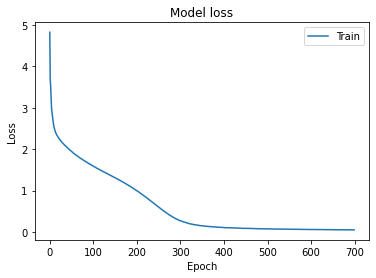

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

generateing the text


In [24]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 512)            34304     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           4724736   
_________________________________________________________________
dense_1 (Dense)              (1, None, 67)             68675     
Total params: 4,827,715
Trainable params: 4,827,715
Non-trainable params: 0
_________________________________________________________________


Prediction loop will generate the text

In [25]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
    predictions = model(input_eval)
    # remove the batch dimension
    predictions = tf.squeeze(predictions, 0)

    # using a categorical distribution to predict the character returned by the model
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    # We pass the predicted character as the next input to the model
    # along with the previous hidden state
    input_eval = tf.expand_dims([predicted_id], 0)

    text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))



In [26]:
print(generate_text(model, start_string=u"Hamlet:"))


Hamlet: Crie
New lighted on a heauen-kissing hill:
A Combination, and a forme indeed,
Where euery God did seeme to set his Seale,
To giue the world assurance of a man.
This was your Husband. Looke you now what forgiue me my Father

   Qu. Calmely good Laertes

   Laer. That drop of blood, that calmes
Proclaimes me Bastard:
Cries Cuckold to my Father, brands the Harlot
Euen heere betweene the chaste vnsmirched by himselfe:
Exchange forgiuenes to the King: They are they keepe:
What company, at what expence: and finding
By this encompassement and drift of question,
That they doe know my sonne: Come you more neerer
Then your particular demands will to Hecuba,
That he should weepe for her? What would he doe,
Had he the Motiue and the Cue for passion
That I haue? He would drowne the Stope of pracis

   Bap, vndertake it Players

   Other. What second in eares.

  King. Now must your conscience my acquittance seal,
And you must put me in your heart for Friend,
Sith you haue heard, and with a 